In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from matplotlib import animation
import scipy

%load_ext tensorboard
import datetime

# Image loading

In [2]:
x_size = 50
y_size = 50

In [3]:
def img_to_vecs(img):
    output = np.zeros((x_size * y_size, 2))
    rescaled_img = 2.0 * img.flatten() - 1.0
    output[:, 0] = np.sin(rescaled_img * np.pi / 2.0)
    output[:, 1] = np.cos(rescaled_img * np.pi / 2.0)
    return output

def vecs_to_img(vecs):
    v = vecs.reshape((x_size, y_size, 2))
    v = v / np.linalg.norm(v, axis=-1, keepdims=True)
    img = np.arcsin(v[:, :, 0:1]) / np.pi * 2.0
    img = (1.0 + img) / 2.0
    img = 255.0 * np.clip(img, 0.0, 1.0)
    return img

In [4]:
num_runs = 200
num_frames = 60
num_t = 3

num_inputs_per_run = num_frames // num_t
num_inputs = num_runs * num_inputs_per_run
X = np.zeros((num_inputs, num_t, x_size * y_size, 2))
for run_idx in range(num_runs):
    for frame_idx in range(0, num_frames, num_t):
        i = run_idx * num_inputs_per_run + frame_idx // num_t
        for t in range(num_t):
            img_path = f"./box_world_1/{str(run_idx).zfill(4)}-{str(frame_idx + t).zfill(4)}.png"
            img = tf.keras.utils.load_img(img_path, color_mode="grayscale", target_size=(x_size, y_size))
            img_arr = tf.keras.utils.img_to_array(img) / 255.0
            X[i][t] = img_to_vecs(img_arr)

In [5]:
X2 = np.zeros((num_inputs, num_t, x_size * y_size, 2))
for run_idx in range(num_runs):
    for frame_idx in range(0, num_frames, num_t):
        i = run_idx * num_inputs_per_run + frame_idx // num_t
        for t in range(num_t):
            img_path = f"./box_world_2/{str(run_idx).zfill(4)}-{str(frame_idx + t).zfill(4)}.png"
            img = tf.keras.utils.load_img(img_path, color_mode="grayscale", target_size=(x_size, y_size))
            img_arr = tf.keras.utils.img_to_array(img) / 255.0
            X2[i][t] = img_to_vecs(img_arr)

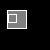

In [21]:
img = vecs_to_img(X2[101][0])
tf.keras.utils.array_to_img(img, scale=False)

# Layer architecture

In [7]:
def stable_norm(t, axis, keepdims=False):
    return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(t), axis=axis, keepdims=keepdims), tf.keras.backend.epsilon()))

def l1_norm(t, axis, keepdims=False):
    return tf.reduce_sum(tf.abs(t), axis=axis, keepdims=keepdims)

### Locality and context layers

In [8]:
class ContextAggregationLayer(tf.keras.layers.Layer):
    def __init__(self, context_fan_in, position_dim, num_samples, initial_sharpness, train_context, dtype=None):
        super(ContextAggregationLayer, self).__init__(dtype=dtype)

        self.context_fan_in = context_fan_in
        self.position_dim = position_dim
        self.num_samples = num_samples
        self.initial_sharpness = initial_sharpness
        self.train_context = train_context
    
    def build(self, input_shape):
        self.downstream_dim = input_shape[-1]
        self.downstream_num = input_shape[-2]

        # Encodes the positions of downstream columns
        # Positions are within a unit ball.
        self.downstream_positions = self.add_weight(
            shape=(self.downstream_num, self.position_dim),
            initializer=self.initialize_positions,
            name='downstream_positions',
            trainable=True,
            use_resource=True,
            constraint=tf.keras.constraints.MaxNorm(max_value=1, axis=1),
        )
        
        # These rotations form the "neighborhood" of a given position.    
        # Shape: position_dim -> position_dim * context_fan_in
        self.context_queries = Dense(
            self.position_dim * self.context_fan_in,
            use_bias=False,
            kernel_initializer=self.initialize_rotations,
            name='context_queries',
            trainable=self.train_context,
            kernel_constraint=self.constrain_to_rotations,
        )
        
        self.context_sharpness = self.add_weight(
            shape=(self.context_fan_in),
            initializer=tf.keras.initializers.Constant(value=self.initial_sharpness),
            name='context_sharpness',
            trainable=True,
            use_resource=True,
        )

        super(ContextAggregationLayer, self).build(input_shape)
    
    def initialize_positions(self, shape, dtype):
        rn = tf.keras.initializers.TruncatedNormal()(shape, dtype=dtype)
        # Initializing to smaller values initially helps positions converge faster.
        return 0.1 * tf.keras.constraints.UnitNorm(axis=1)(rn)
    
    def constrain_to_rotations(self, a):
        rs = tf.split(a, self.context_fan_in, axis=1)
        constrained_rs = []
        for r in rs:
            s, u, v = tf.linalg.svd(r)
            vh = tf.linalg.adjoint(v)
            constrained_rs.append(tf.matmul(u, vh))
            
        return tf.concat(constrained_rs, axis=1)
    
    def initialize_rotations(self, shape, dtype):
        identity = tf.keras.initializers.Identity()((self.position_dim, self.position_dim), dtype=dtype)
        rotations = []
        # The first rotation is always the identity (i.e. the seed value itself)
        rotations.append(identity)
        for i in range(1, self.context_fan_in):
            rotation = tf.keras.initializers.Orthogonal(gain=0.1)((self.position_dim, self.position_dim), dtype=dtype)
            rotations.append(identity + rotation)
        rotations = tf.concat(rotations, axis=1)
        return self.constrain_to_rotations(rotations)
    
    def sample_seed_indexes(self):
        # This tensorflow sampling method is inspired by https://stackoverflow.com/a/54755281
        # It approximates Numpy's np.random.choice with replace=False
        # Sampling different seed indexes for each batch helps the positions and contexts
        # to converge better to true neighborhoods. I was previously using a fixed sampling
        # throughout the whole training, and it led to the seed positions to get stuck
        # in specific values that didn't resemble their neighbors.

        uniform_distribution = tf.random.uniform([self.downstream_num], minval=0.0, maxval=1.0)
        _, top_indexes = tf.nn.top_k(uniform_distribution, self.num_samples)

        return top_indexes
    
    def reconstruct(self, full_context):        
        # Position shape: (..., num_columns, position_dim)
        # Value shape: (..., num_columns, context_fan_in * downstream_dim)
        position, values = tf.split(
            full_context,
            [
                self.position_dim,
                self.context_fan_in * self.downstream_dim,
            ],
            axis=-1,
        )
        
        # Restore scale
        values *= np.sqrt(self.context_fan_in)

        # Shape: (context_fan_in, ..., num_columns, downstream_dim)
        values = tf.stack(tf.split(values, self.context_fan_in, axis=-1), axis=0)

        # Shape: (..., num_columns, context_fan_in * position_dim)
        queries = self.context_queries(position)
        
        # Shape: (context_fan_in, ..., num_columns, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Needed so we can call reconstruct directly when in mixed precision
        cast_downstream_positions = tf.cast(self.downstream_positions, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)
        queries = tf.cast(queries, self.compute_dtype)
        values = tf.cast(values, self.compute_dtype)
        
        # Process heads in sequence to reduce memory footprint
        reconstruction_shape = tf.concat([tf.shape(full_context)[0:-2], [self.downstream_num, self.downstream_dim]], axis=0)
        reconstruction = tf.zeros(reconstruction_shape, dtype=full_context.dtype)
        for head_idx in tf.range(0, self.context_fan_in):
            # Shape: (..., num_columns, position_dim)
            head_query = queries[head_idx]
            # Shape: (..., num_columns, downstream_dim)
            head_values = values[head_idx]
            # Shape: (1)
            head_sharpness = exp_sharpness[head_idx]
            # Shape: (..., num_samples, downstream_dim)
            head_output = self.compute_reconstruction_head_output(
                cast_downstream_positions,
                head_values,
                head_query,
                head_sharpness,
            )
            reconstruction = reconstruction + tf.cast(head_output, full_context.dtype)

        return reconstruction

    def call(self, downstream_input):
        # Shape: (num_samples, position_dim)
        seed_positions = tf.gather(self.downstream_positions, self.sample_seed_indexes(), axis=-2)
        
        # Shape: (num_samples, context_fan_in * position_dim)
        queries = self.context_queries(seed_positions)
        
        # Shape: (context_fan_in, num_samples, position_dim)
        queries = tf.stack(tf.split(queries, self.context_fan_in, axis=-1), axis=0)
        
        # Shape: (context_fan_in)
        exp_sharpness = tf.exp(self.context_sharpness)
        
        # Cast for mixed precision
        queries = tf.cast(queries, self.compute_dtype)
        exp_sharpness = tf.cast(exp_sharpness, self.compute_dtype)
        
        # Process heads in sequence to reduce memory footprint
        head_buffer = tf.TensorArray(dtype=self.compute_dtype, size=self.context_fan_in, clear_after_read=True)
        for head_idx in tf.range(0, self.context_fan_in):
            # Shape: (..., num_samples, position_dim)
            head_query = queries[head_idx]
            # Shape: (1)
            head_sharpness = exp_sharpness[head_idx]
            # Shape: (..., num_samples, downstream_dim)
            head_output = self.compute_attention_head_output(self.downstream_positions, downstream_input, head_query, head_sharpness)
            head_buffer = head_buffer.write(head_idx, head_output)

        # Restore scale
        head_values = head_buffer.stack() / np.sqrt(self.context_fan_in)
        head_values = tf.unstack(head_values)
        
        # Shape: (..., num_samples, position_dim + context_fan_in * downstream_dim)
        expanded_seed_positions = tf.broadcast_to(
            seed_positions,
            tf.concat([tf.shape(head_values[0])[0:-1], [self.position_dim]], axis=0),
        )
        full_context = tf.concat([expanded_seed_positions] + head_values, axis=-1)

        return full_context
    
    @staticmethod
    @tf.function(jit_compile=True)
    #@tf.recompute_grad
    def compute_attention_head_output(downstream_positions, downstream_input, query, sharpness):
        # Shape: (downstream_num, position_dim), (num_samples, position_dim) -> (num_samples, downstream_num)
        attention_similarities = sharpness * tf.einsum('ND,SD->SN', downstream_positions, query)

        # Shape: (num_samples, downstream_num) -> (num_samples, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Shape: (..., downstream_num, downstream_dim), (num_samples, downstream_num) -> (..., num_samples, downstream_dim)
        head_output = tf.einsum('...ND,SN->...SD', downstream_input, attention_scores)
        
        return head_output
    
    @staticmethod
    @tf.function(jit_compile=True)
    @tf.recompute_grad
    def compute_reconstruction_head_output(downstream_positions, values, query, sharpness):
        # Shape: (downstream_num, position_dim), (..., num_columns, position_dim) -> (..., num_columns, downstream_num)
        attention_similarities = sharpness * tf.einsum('ND,...SD->...SN', downstream_positions, query)
        
        # Shape: (..., num_columns, downstream_num) -> (..., num_columns, downstream_num)
        attention_scores = tf.nn.softmax(attention_similarities, axis=-1)
        
        # Shape: (..., num_columns, downstream_dim), (..., num_columns, downstream_num) -> (..., downstream_num, downstream_dim)
        head_reconstruction = tf.einsum('...CD,...CN->...ND', values, attention_scores)
        
        return head_reconstruction

### Coding / decoding layer

In [9]:
def compute_full_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Like cosine similarity, but weighted by the norm of the true vectors
    similarity = tf.reduce_sum(y_true * tf.math.l2_normalize(y_pred, axis=-1, epsilon=tf.keras.backend.epsilon()), axis=-1)
    weights = stable_norm(y_true, axis=-1)

    # Quadratic formulation. The idea behind this is to put more emphasis on reconstructing vectors *approximately*
    # correctly, rather than exactly correctly.
    return 4 * tf.reduce_mean(tf.square(weights - similarity))
    # Linear formulation
    #return tf.reduce_mean(weights - similarity)

def compute_partial_reconstruction_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compare the L1 norm size change when adding y_pred vectors to y_true vectors
    norm_y_true = y_true / tf.maximum(l1_norm(y_true, axis=-1, keepdims=True), tf.keras.backend.epsilon())
    norm_y_pred = y_pred / tf.maximum(l1_norm(y_pred, axis=-1, keepdims=True), tf.keras.backend.epsilon())
    weights = stable_norm(y_true, axis=-1)
    partial_loss = weights * (2.0 - l1_norm(norm_y_true + norm_y_pred, axis=-1))
    
    return tf.reduce_mean(partial_loss)

def compute_scale_error(y_true, y_pred):
    y_true = tf.cast(tf.stop_gradient(y_true), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Alternative formulation: Scale in the "correct direction" (norm of differences)
    #diffs = stable_norm(y_true - y_pred, axis=-1)
    
    # Traditional formulation (scale only):
    # Penalize scale differences between y_true and y_pred
    diffs = tf.abs(stable_norm(y_true, -1) - stable_norm(y_pred, -1))

    return tf.reduce_mean(diffs)

def mean_l1_activity(t):
    t = tf.cast(t, tf.float32)
    return tf.reduce_mean(tf.reduce_sum(tf.abs(t), axis=-1))

def mean_l2_activity(t):
    t = tf.cast(t, tf.float32)
    return tf.reduce_mean(tf.reduce_sum(tf.square(t), axis=-1))

class PermanenceSeparatorLayer(tf.keras.layers.Layer):
    def __init__(self, upstream_dim, position_dim, noise_rate):
        super(PermanenceSeparatorLayer, self).__init__()
        
        self.upstream_dim = upstream_dim
        self.position_dim = position_dim
        self.noise_rate = noise_rate
    
    def build(self, input_shape):
        self.internal_dim = input_shape[-1]

        separation_initializer_stddev = np.sqrt(2 / self.internal_dim)
        reconstruction_initializer_stddev = 0.1 * np.sqrt(2 / self.upstream_dim)

        self.separation_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.upstream_dim,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=separation_initializer_stddev),
                name='separation_layer_3',
            ),
        ]
        
        self.reconstruction_layers = [
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_1',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                np.ceil(2 * self.internal_dim / 8.0) * 8,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_2',
            ),
            LeakyReLU(alpha=0.1),
            Dense(
                self.internal_dim,
                use_bias=False,
                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=reconstruction_initializer_stddev),
                name='reconstruction_layer_3',
            )
        ]
        
        super(PermanenceSeparatorLayer, self).build(input_shape)
     
    @tf.function(jit_compile=True)
    def reconstruct(self, separated_input, training=False):
        # Inject noise to increase robustness.
        if self.noise_rate and training:
            noise = tf.random.normal(
                shape=tf.shape(separated_input),
                mean=0.0,
                stddev=self.noise_rate/np.sqrt(self.upstream_dim),
                dtype=separated_input.dtype,
            )
            separated_input += tf.stop_gradient(noise)
        
        enriched_input = separated_input
        for l in self.reconstruction_layers:
            enriched_input = l(enriched_input)
        
        return enriched_input
    
    def call(self, enriched_input, training):        
        separated_input = enriched_input
        for l in self.separation_layers:
            separated_input = l(separated_input)
        
        # Try to keep the state sparse if we can - this makes the work of upstream layers easier, and encourages
        # the encoder to identify distinct recurring patterns in the inputs.
        activity_reg = mean_l1_activity(separated_input)
        self.add_metric(activity_reg, 'mean_l1_activity')
        self.add_loss(0.01 * activity_reg)

        return separated_input

### Single column type

In [10]:
class ColumnSelectorLayer(tf.keras.layers.Layer):
    def __init__(self, num_column_instances):
        super(ColumnSelectorLayer, self).__init__()
    
        self.num_column_instances = num_column_instances
        
    def build(self, input_shape):
        self.upstream_dim = input_shape[-1]
        
        # One query per column instance.
        self.instance_queries = self.add_weight(
            shape=(self.num_column_instances, self.upstream_dim),
            initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=np.sqrt(2.0 / self.upstream_dim)),
            name='instance_queries',
            use_resource=True,
            trainable=True,
        )
        
        self.instance_sharpness = self.add_weight(
            shape=(self.num_column_instances,),
            initializer=tf.keras.initializers.Constant(3.0),
            name='instance_sharpness',
            use_resource=True,
            trainable=True,
        )
        
        # How much of the previous instance activation we add to the queries at the next
        # time step. This is to facilitate "lock on" behavior to improve permanence.
        self.stickiness = self.add_weight(
            shape=(self.num_column_instances,),
            initializer=tf.keras.initializers.Constant(0.1),
            constraint=tf.keras.constraints.NonNeg(),
            name='stickiness',
            use_resource=True,
            trainable=True,
        )
        
        super(ColumnSelectorLayer, self).build(input_shape)
    
    def call(self, upstream_candidates):        
        # We propagate selected inputs through time, so enable "locking on" to a particular input.
        num_time_steps = tf.shape(upstream_candidates)[1]
        
        selected_inputs_shape_at_t = [tf.shape(upstream_candidates)[0], self.num_column_instances, self.upstream_dim]
        
        # Initialize to self.queries to have the same magnitude at t=0 as at subsequent time steps
        previous_selected_inputs = tf.broadcast_to(self.instance_queries, selected_inputs_shape_at_t)
        selected_inputs_buffer = tf.TensorArray(dtype=upstream_candidates.dtype, size=num_time_steps, clear_after_read=True)
        for t_idx in tf.range(0, num_time_steps):
            upstream_candidates_at_t = upstream_candidates[:, t_idx, :, :]
            instance_queries_at_t = (
                self.instance_queries +
                tf.einsum('I,...ID->...ID', self.stickiness, previous_selected_inputs)
            )
            instance_queries_at_t = tf.math.l2_normalize(instance_queries_at_t, axis=-1, epsilon=tf.keras.backend.epsilon())
            instance_queries_at_t = tf.einsum(
                'I,...ID->...ID',
                tf.math.exp(self.instance_sharpness),
                instance_queries_at_t,
            )

            # Have each column instance compete for the samples
            # Shape: (..., num_samples, upstream_dim), (..., num_column_instances, upstream_dim) -> (..., num_samples, num_column_instances)
            instance_interests = tf.einsum('...SD,...ID->...SI', upstream_candidates_at_t, instance_queries_at_t)

            # Compute softmax over num_column_instances to "assign" each input to one column instance
            column_selection = tf.nn.softmax(instance_interests, axis=-1)

            # Shape: (..., num_samples, num_column_instances), (..., num_samples, upstream_dim) -> (..., num_column_instances, upstream_dim)
            selected_inputs_at_t = tf.einsum('...SI,...SD->...ID', column_selection, upstream_candidates_at_t)

            previous_selected_inputs = selected_inputs_at_t
            selected_inputs_buffer = selected_inputs_buffer.write(t_idx, selected_inputs_at_t)

        # Concatenate the results for each time index back together into a single tensor
        # Shape: (num_time_steps, ..., num_column_instances, upstream_dim)
        selected_inputs = selected_inputs_buffer.stack()
        # Shape: (..., num_time_steps, num_column_instances, upstream_dim)
        selected_inputs = tf.transpose(selected_inputs, perm=[1, 0, 2, 3])

        return selected_inputs
        
class ColumnLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        upstream_dim,
        num_column_instances,
        position_dim,
        context_fan_in,
        context_num_samples,
        context_initial_sharpness,
        train_context,
        noise_rate,
    ):
        super(ColumnLayer, self).__init__()

        self.upstream_dim = upstream_dim
        self.num_column_instances = num_column_instances
        self.position_dim = position_dim
        self.context_fan_in = context_fan_in
        self.context_num_samples = context_num_samples
        self.context_initial_sharpness = context_initial_sharpness
        self.train_context = train_context
        self.noise_rate = noise_rate
    
    def build(self, input_shape):        
        self.context_aggregator = ContextAggregationLayer(
            context_fan_in=self.context_fan_in,
            position_dim=self.position_dim,
            num_samples=self.context_num_samples,
            initial_sharpness=self.context_initial_sharpness,
            train_context=self.train_context,
            # mixed_float16 is supported, but actually runs more slowly on the current architecture.
            # dtype='mixed_float16',
            dtype='float32',
        )
        
        self.permanence_separator = PermanenceSeparatorLayer(
            upstream_dim=self.upstream_dim,
            position_dim=self.position_dim,
            noise_rate=self.noise_rate,
        )
        
        self.column_selector = ColumnSelectorLayer(
            num_column_instances=self.num_column_instances,
        )
        
        super(ColumnLayer, self).build(input_shape)
    
    def reconstruct(self, upstream_state):
        reconstruction = self.permanence_separator.reconstruct(upstream_state)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        return reconstruction
    
    def call(self, downstream_input, training):
        # Aggregate contexts
        enriched_input = self.context_aggregator(downstream_input)
        
        # Compute upstream state candidates by converting inputs into their permanence-separated representations
        upstream_candidates = self.permanence_separator(enriched_input)

        # Select a finite set of them
        upstream_state = self.column_selector(upstream_candidates)

        # Compute a reconstruction of the downstream input
        reconstruction = self.permanence_separator.reconstruct(upstream_state, training=training)
        reconstruction = self.context_aggregator.reconstruct(reconstruction)
        
        return [upstream_state, reconstruction]

### Multi-column overall layer

In [74]:
def compute_change_non_sparseness(cur_state, future_states, bias, diff_scale_factor):    
    diff = future_states - cur_state
    l1 = l1_norm(diff, axis=-1)
    # Minimum is to avoid negative values due to the espilon in stable_norm
    l2 = tf.minimum(l1, stable_norm(diff, axis=-1))

    non_sparseness = (l1 + bias) / (l2 + bias) - 1.0
    
    # Also slightly penalize the absolute scale of the difference.
    # If we don't have this regularizer, then networks can easily learn to bypass the permanence loss
    # by creating a single component that responds to minor noise and changes with large magnitude, thereby
    # making change always look sparse.
    lin_scale = l1
    sq_scale = tf.reduce_sum(tf.square(diff), axis=-1)
    
    return non_sparseness + diff_scale_factor * (lin_scale + sq_scale)

def compute_permanence_loss(cur_upstream_state, future_upstream_states, cur_reconstruction, future_reconstructions):
    cur_upstream_state = tf.cast(cur_upstream_state, tf.float32)
    future_upstream_states = tf.cast(future_upstream_states, tf.float32)
    # Reconstruction differences are used for normalization of the permanence loss. The bigger the
    # reconstruction difference, the more weight we give the the permanence loss. This supports early
    # convergence of the network, as it only starts applying permanence loss pressure as the network
    # starts reconstructing differences between states.
    cur_reconstruction = tf.cast(tf.stop_gradient(cur_reconstruction), tf.float32)
    future_reconstructions = tf.cast(tf.stop_gradient(future_reconstructions), tf.float32)
    
    bias = 0.1
    diff_scale_factor = 0.1
    
    upstream_non_sparseness = tf.reduce_mean(
        compute_change_non_sparseness(
            cur_upstream_state,
            future_upstream_states,
            bias=bias,
            diff_scale_factor=diff_scale_factor,
        ),
        axis=-1,
    )
    
    reconstruction_diff_scale = tf.reduce_mean(stable_norm(future_reconstructions - cur_reconstruction, axis=-1))
    
    scaled_non_sparseness = reconstruction_diff_scale * upstream_non_sparseness
    
    return tf.reduce_mean(scaled_non_sparseness)

class PtolemyLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        num_channels,
        num_instances_per_channel,
        context_fan_in,
        upstream_dim,
        position_dim,
        stride=1,
        permanence_loss_rho=0.1,
        initial_sharpness=3.0,
        noise_rate=0.1,
        train_context=True,
        add_default=False,
        train_default=True,
    ):
        super(PtolemyLayer, self).__init__()
        
        self.num_channels = num_channels
        self.num_instances_per_channel = num_instances_per_channel
        self.context_fan_in = context_fan_in
        self.upstream_dim = upstream_dim
        self.position_dim = position_dim
        self.stride = stride
        self.permanence_loss_rho = permanence_loss_rho
        self.initial_sharpness = initial_sharpness
        self.noise_rate = noise_rate
        self.train_context = train_context
        self.add_default = add_default
        self.train_default = train_default
    
    def get_config(self):
        return {
            'num_channels': self.num_channels,
            'num_instances_per_channel': self.num_instances_per_channel,
            'context_fan_in': self.context_fan_in,
            'upstream_dim': self.upstream_dim,
            'position_dim': self.position_dim,
            'stride': self.stride,
            'permanence_loss_rho': self.permanence_loss_rho,
            'initial_sharpness': self.initial_sharpness,
            'noise_rate': self.noise_rate,
            'train_context': self.train_context,
            'add_default': self.add_default,
            'train_default': self.train_default,
        }
    
    def build(self, input_shape):
        self.downstream_num = input_shape[-2]
        self.downstream_dim = input_shape[-1]
        
        num_samples = int(self.downstream_num / self.stride)
        
        self.columns = []
        for c in range(0, self.num_channels):
            self.columns.append(
                ColumnLayer(
                    upstream_dim=self.upstream_dim,
                    num_column_instances=self.num_instances_per_channel,
                    position_dim=self.position_dim,
                    context_fan_in=self.context_fan_in,
                    context_num_samples=num_samples,
                    context_initial_sharpness=self.initial_sharpness,
                    train_context=self.train_context,
                    noise_rate=self.noise_rate,
                )
            )
        
        if self.add_default:
            self.default = self.add_weight(
                shape=(self.downstream_num, self.downstream_dim),
                trainable=self.train_default,
                initializer=tf.keras.initializers.Zeros(),
                use_resource=True,
                name='default',
            )
        else:
            self.default = None
        
        super(PtolemyLayer, self).build(input_shape)
    
    @tf.function(jit_compile=True)
    def reconstruct(self, upstream_state):
        upstream_states = tf.split(upstream_state, self.num_channels, axis=-2)
        channel_reconstructions = []
        for c in range(0, self.num_channels):
            channel_reconstruction = self.columns[c].reconstruct(upstream_states[c])
            channel_reconstructions.append(channel_reconstruction)
            
        reconstruction = self.reconstruct_from_channel_reconstructions(channel_reconstructions)
        
        return reconstruction
    
    def reconstruct_from_channel_reconstructions(self, channel_reconstructions):       
        reconstruction = tf.math.add_n(channel_reconstructions)

        if self.add_default:
            reconstruction += tf.cast(self.default, self.compute_dtype)
        
        return reconstruction
    
    def call(self, downstream_input, training=False):
        if self.add_default and not self.train_default:
            # Update default to be the mean of the inputs
            batch_mean = tf.reduce_mean(tf.reduce_mean(tf.cast(downstream_input, tf.float32), axis=0), axis=0)
            if training:
                self.default.assign(0.9 * tf.cast(self.default, tf.float32) + 0.1 * batch_mean)
    
        upstream_states = []
        channel_reconstructions = []
        for c in range(0, self.num_channels):
            upstream_state, channel_reconstruction = self.columns[c](
                downstream_input,
            )
 
            upstream_states.append(upstream_state)
            channel_reconstructions.append(channel_reconstruction)
        
        upstream_state = tf.concat(upstream_states, axis=-2)
        reconstruction = self.reconstruct_from_channel_reconstructions(channel_reconstructions)

        if self.permanence_loss_rho:
            # Compute pairwise permanence losses of all time steps compared to the 0th step
            permanence_loss = compute_permanence_loss(
                upstream_state[:, :1],
                upstream_state[:, 1:],
                reconstruction[:, :1],
                reconstruction[:, 1:],
            )
            self.add_metric(permanence_loss, 'permanence_loss')
            self.add_loss(self.permanence_loss_rho * permanence_loss)
        
        reconstruction_error = compute_full_reconstruction_error(tf.stop_gradient(downstream_input), reconstruction)
        self.add_metric(reconstruction_error, 'reconstruction_error')
        self.add_loss(reconstruction_error)
        
        scale_error = compute_scale_error(downstream_input, reconstruction)
        self.add_metric(scale_error, 'scale_error')
        self.add_loss(0.1 * scale_error)

        return [upstream_state, reconstruction]

# Model

In [75]:
inp = Input(shape=(3, x_size * y_size, 2))
l1 = PtolemyLayer(
   num_channels=1,
   num_instances_per_channel=16,
   context_fan_in=32,
   upstream_dim=40,
   position_dim=32,
   stride=5,
   permanence_loss_rho=0.1,
   initial_sharpness=3.0,
   add_default=True,
   noise_rate=0.1,
)

upstream_state_1, downstream_reconstruction_1 = l1(inp)

upstream_state = upstream_state_1
downstream_reconstruction = downstream_reconstruction_1

In [76]:
reconstruction_model = tf.keras.models.Model(inputs=[inp], outputs=downstream_reconstruction)
upstream_state_model = tf.keras.models.Model(inputs=[inp], outputs=upstream_state)

@tf.function
def zero_loss(t, p):
    return 0.0

optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.001,
    #clipnorm=0.1,
)
#optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)
reconstruction_model.compile(
    loss = zero_loss,
    optimizer = optimizer,
    metrics = ['cosine_similarity'],
)
reconstruction_model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 3, 2500, 2)]      0         
                                                                 
 ptolemy_layer_12 (PtolemyL  [(None, None, 16, 40),    244424    
 ayer)                        (None, None, 2500, 2)]             
                                                                 
Total params: 244424 (954.78 KB)
Trainable params: 244424 (954.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
log_dir = "ptolemynet_logs/fit_layer1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

tf.config.experimental.reset_memory_stats('GPU:0')
X_1 = np.concatenate((X, X2))
#X_1 = X
history = reconstruction_model.fit([X_1], X_1, epochs=128, batch_size=64, callbacks=[tensorboard_callback])
tf.config.experimental.get_memory_info('GPU:0')

Epoch 1/128
 36/125 [=======>......................] - ETA: 16s - loss: 0.1466 - cosine_similarity: 0.9593 - permanence_loss: 0.2344 - reconstruction_error: 0.1022 - scale_error: 0.1855 - mean_l1_activity: 0.2361

KeyboardInterrupt: 

In [ ]:
#reconstruction_model.save('ptolemy_model_saves/2021-11-18_PtolemyNet31_mnist_layer1')

In [91]:
print('context sharpness', l1.columns[0].context_aggregator.context_sharpness.numpy())
print('instance_sharpness', l1.columns[0].column_selector.instance_sharpness.numpy())
print('stickiness', l1.columns[0].column_selector.stickiness.numpy())

context sharpness [2.6464388 3.1983836 2.9100325 2.908774  2.958603  2.8402886 3.1335518
 2.5074396 3.4335823 3.3292294 3.3852327 3.0921822 3.609473  2.9546738
 3.1735432 3.453924  3.5433795 3.240994  3.2846622 3.2769117 3.5754757
 3.6122873 2.6800134 3.3666742 2.9932966 2.1760802 3.3854496 3.1166945
 3.0654547 3.529062  3.3832684 3.5040305]
instance_sharpness [3.7654607 4.4656286 7.02694   3.5745468 7.6222906 7.3514233 7.528465
 4.6192775 3.6535516 7.630462  7.173425  4.0367136 4.1028047 7.5123277
 7.286149  6.973825 ]
stickiness [ 0.00059343  0.00214174  0.41838312  0.00424639  0.03782145  0.4073644
  0.20356396  0.00065986  0.00339905 -0.          0.41658816  0.00316029
  0.00100319  0.10999686  0.03124692  0.197579  ]


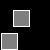

In [92]:
x = X[570]
x = X2[518]
x_img = vecs_to_img(x[0])
tf.keras.utils.array_to_img(x_img, scale=False)

1/1 [==============================] - 0s 32ms/step
-1.5016367
4.1229606
norm of x 1.0000000033069503
norm of y 0.81320286
0.0
224.16882


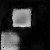

In [93]:
y = reconstruction_model.predict(tf.reshape(x, (1, 3, x_size * y_size, 2)))
print(tf.reduce_min(y[0][0]).numpy())
print(tf.reduce_max(y[0][0]).numpy())
print('norm of x', tf.reduce_mean(tf.norm(x[0], axis=-1)).numpy())
print('norm of y', tf.reduce_mean(tf.norm(y[0][0], axis=-1)).numpy())
y_img = vecs_to_img(tf.squeeze(y[0][0]).numpy())
print(tf.reduce_min(y_img).numpy())
print(tf.reduce_max(y_img).numpy())
tf.keras.utils.array_to_img(y_img, scale=False)

shape (16, 40)
min -5.4288645
max 4.048527
norm 13.230119
max of diff 2.8150485
norm of diff 4.248431


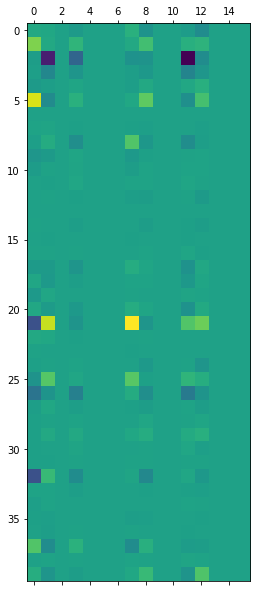

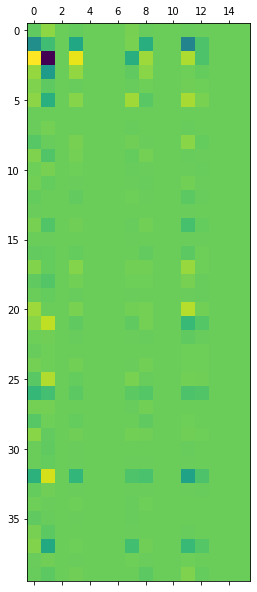

In [95]:
us = reconstruction_model.get_layer(index=1)(x.reshape((1, 3, x_size * y_size, 2)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
one_us = one_us[0]
print('shape', one_us.shape)
print('min', tf.reduce_min(one_us).numpy())
print('max', tf.reduce_max(one_us).numpy())
print('norm', tf.norm(one_us).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us.numpy().T)
plt.matshow(usd.numpy().T)

norm of diff 25.672327
(1, 3, 16, 40)
[ 3.2124373e-01  7.7296925e-01  5.8200204e-01  4.8214799e-01
 -1.9967726e-01  4.3125310e+00  1.8850255e-03  1.9494317e-02
 -9.8178610e-02 -2.2241095e-01 -1.7166564e-01 -1.3424280e-01
 -3.8359247e-02 -3.3940021e-03 -2.6633361e-02 -8.0580413e-03
  2.2278775e-01  2.5483173e-01  5.6557264e-02 -2.6413557e-01
  2.6366517e-01 -2.7532563e+00  2.7753574e-01 -2.4893796e-03
  6.5436751e-02 -6.3583899e-01 -3.8916018e+00  3.7327547e-02
  1.5720120e-02  5.1082000e-03 -7.3801190e-02 -9.4919065e-03
 -2.2263634e-01  5.8298163e-02  1.3550630e-01  2.4156038e-02
  2.3792695e-02  7.5354266e-01  1.1359645e-02  2.2152939e-01]
(1, 3, 2500, 2)


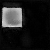

In [96]:
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[2], (1, 3, x_size * y_size, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[4], (1, 3, x_size * y_size, 2)), training=False)[0]
us1 = tf.cast(us1, tf.float32)
us2 = tf.cast(us2, tf.float32)
print('norm of diff', tf.norm(us2-us1).numpy())
us_mod = (us1 + 0.0 * (us2 - us1)).numpy()
print(us_mod.shape)
print(us_mod[0][0][0])
#us_mod[0][0][10] = np.zeros((40))
#us_mod[0][0][1] = np.zeros((40))
#us_mod[0][0][0][15] = 0.2
r = l1.reconstruct(tf.cast(us_mod, tf.float32))
print(r.shape)
r_one = r[0][0]
r_img = vecs_to_img(tf.squeeze(r_one).numpy())
tf.keras.utils.array_to_img(r_img, scale=False)

In [ ]:
le = l1.columns[0].context_aggregator.downstream_positions.numpy()
le = le.reshape((x_size,y_size,-1))
print(tf.reduce_min(le[:, :, 0]).numpy())
print(tf.reduce_max(le[:, :, 0]).numpy())
for d in range(0, le.shape[2]):
    plt.matshow(le[:, :, d])

# Layer 2

In [ ]:
X_2 = upstream_state_model.predict(np.concatenate((X, X2)), batch_size=64)
#X_2 = upstream_state_model.predict(X, batch_size=64)

Y_2 = X_2

In [ ]:
inp_2 = Input(shape=(3, 16, 40))
l2 = PtolemyLayer(
    num_channels=1,
    num_instances_per_channel=4,
    context_fan_in=16,
    upstream_dim=8,
    position_dim=8,
    stride=1,
    permanence_loss_rho=0.1,
    initial_sharpness=3.0,
    noise_rate=0.1,
    add_default=False,
)

upstream_state_2, downstream_reconstruction_2 = l2(inp_2)

reconstruction_model_2 = tf.keras.models.Model(inputs=[inp_2], outputs=downstream_reconstruction_2)
upstream_state_model_2 = tf.keras.models.Model(inputs=[inp_2], outputs=upstream_state_2)

optimizer_2 = tf.keras.optimizers.Adam(
    learning_rate = 0.001,
    clipnorm=0.1,
)
optimizer_2 = tf.keras.mixed_precision.LossScaleOptimizer(optimizer_2)
reconstruction_model_2.compile(
    loss = zero_loss,
    optimizer = optimizer_2,
    metrics = ['cosine_similarity'],
)
reconstruction_model_2.summary()

In [ ]:
log_dir = "ptolemynet_logs/fit_layer2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True)

tf.config.experimental.reset_memory_stats('GPU:0')
history = reconstruction_model_2.fit([X_2], Y_2, epochs=128, batch_size=64, callbacks=[tensorboard_callback])
tf.config.experimental.get_memory_info('GPU:0')

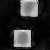

In [114]:
x_2 = X_2[4500]
x_2_img = vecs_to_img(l1.reconstruct(tf.cast(x_2, tf.float32))[0].numpy())
tf.keras.utils.array_to_img(x_2_img, scale=False)

1/1 [==============================] - 0s 28ms/step


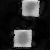

In [115]:
y_2 = reconstruction_model_2.predict(tf.reshape(x_2, (1, 3, 16, 40)))[0]
y_2_img = vecs_to_img(l1.reconstruct(tf.cast(y_2, tf.float32))[0].numpy())
tf.keras.utils.array_to_img(y_2_img, scale=False)

14.320402
13.654631


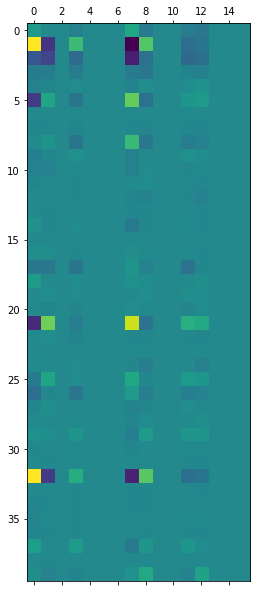

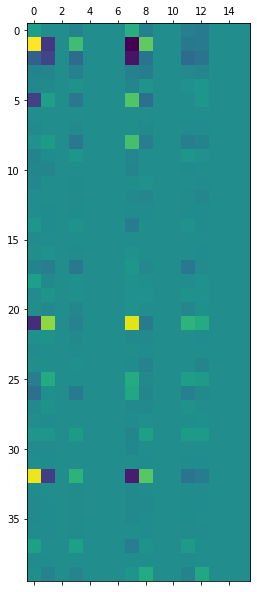

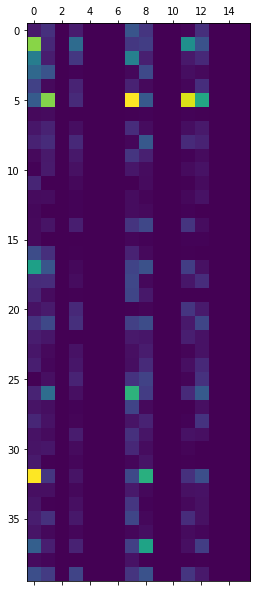

In [116]:
plt.matshow(tf.cast(x_2[0], tf.float32).numpy().T)
plt.matshow(tf.cast(y_2[0], tf.float32).numpy().T)
print(tf.norm(x_2[0]).numpy())
print(tf.norm(y_2[0]).numpy())
rd = tf.cast(x_2[0], tf.float32).numpy() - tf.cast(y_2[0], tf.float32).numpy()
plt.matshow(np.abs(rd.T), vmin=0.0, vmax=0.5)

shape (4, 8)
min -0.7601449
max 1.3456047
norm 1.8169454
max of diff 0.2580576
norm of diff 0.28103876


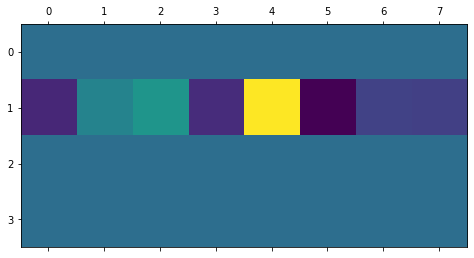

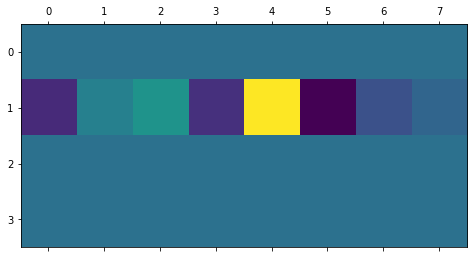

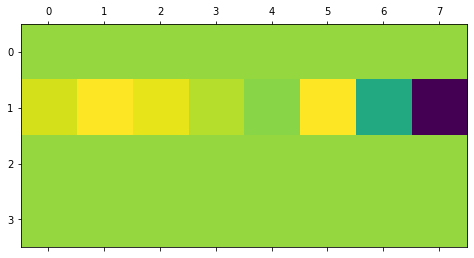

In [117]:
us = reconstruction_model_2.get_layer(index=1)(x_2.reshape((1, 3, 16, 40)), training=False)[0]
us = tf.cast(us, tf.float32)
one_us = us[0]
usd = one_us[0] - one_us[1]
print('shape', one_us[0].shape)
print('min', tf.reduce_min(one_us[0]).numpy())
print('max', tf.reduce_max(one_us[0]).numpy())
print('norm', tf.norm(one_us[0]).numpy())
print('max of diff', tf.reduce_max(tf.abs(usd)).numpy())
print('norm of diff', tf.norm(usd).numpy())
plt.matshow(one_us[0].numpy())
plt.matshow(one_us[1].numpy())
plt.matshow(usd.numpy())

(1, 3, 4, 8)


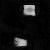

In [108]:
us_mod = us.numpy()
print(us_mod.shape)
us_mod[0][0][0] = np.zeros((8))
#us_mod[0][0][1] = np.zeros((8))
us_mod[0][0][2] = np.zeros((8))
us_mod[0][0][3] = np.zeros((8))

#us_mod[0][0][0] *= 3
us_mod[0][0][1][0] = 0.5

#us_mod[0][0] = us_mod[0][0] + 2.0 * (us_mod[0][1] - us_mod[0][0])
r = l2.reconstruct(us_mod)
r = l1.reconstruct(r)
y_2_mod_img = vecs_to_img(r[0][0].numpy())
tf.keras.utils.array_to_img(y_2_mod_img, scale=False)

## Exports and animations

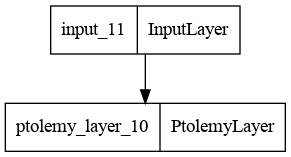

In [68]:
tf.keras.utils.plot_model(reconstruction_model, expand_nested=True)

In [69]:
def animate_interpolation(x1, x2, reconstruction_fun, filename, min_coeff=0.0, max_coeff=1.0, steps=20):
    fig = plt.figure()
    animate = lambda i: reconstruction_fun(x1 + (min_coeff + float(i) / steps * (max_coeff - min_coeff)) * (x2 - x1))
    anim = animation.FuncAnimation(fig, animate, frames=steps, interval=100, blit=True)
    anim.save(filename, fps=15, writer='imagemagick')
    plt.close(fig)

In [70]:
def reconstruct_l1(x):
    recon = l1.reconstruct(x)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = tf.keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

def reconstruct_l2(x):
    recon = l2.reconstruct(x)
    recon = l1.reconstruct(recon)[0][0]
    recon_im_array = vecs_to_img(tf.squeeze(recon).numpy())
    recon_im = tf.keras.utils.array_to_img(recon_im_array, scale=False)
    return plt.imshow(recon_im, cmap='gray', vmin=0, vmax=255),

In [102]:
#us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X[0], (1, 2, 28*28, 2)), training=False)[0]
#us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X[1], (1, 2, 28*28, 2)), training=False)[0]
us1 = reconstruction_model.get_layer(index=1)(tf.reshape(X2[1], (1, 3, 2500, 2)), training=False)[0]
us2 = reconstruction_model.get_layer(index=1)(tf.reshape(X2[5], (1, 3, 2500, 2)), training=False)[0]

animate_interpolation(us1, us2, reconstruct_l1, 'l1_test.gif', min_coeff=0.0, max_coeff=1.0, steps=40)

In [103]:
us1 = reconstruction_model_2.get_layer(index=1)(tf.reshape(X_2[4001], (1, 3, 16, 40)), training=False)[0]
us2 = reconstruction_model_2.get_layer(index=1)(tf.reshape(X_2[4005], (1, 3, 16, 40)), training=False)[0]

animate_interpolation(us1, us2, reconstruct_l2, 'l2_test.gif', min_coeff=0.0, max_coeff=1.0, steps=40)

In [113]:
for coordinate in range(8):
    us1_mod1 = us.numpy()
    us1_mod2 = us.numpy()
    us1_mod1[0][0][1][coordinate] = 0.0
    us1_mod2[0][0][1][coordinate] = 1.0

    animate_interpolation(us1_mod1, us1_mod2, reconstruct_l2, f'level_2_boxworld_coordinate_{coordinate}.gif', min_coeff=-1.0, max_coeff=1.0, steps=80)